# Importing libraries

In [ ]:
import math
import random
import time
from math import exp

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from numpy import *
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [3]:
from Bayesneuralnet_regcls import MCMC, Network, scikit_linear_mod

# Setting model parameters and datasets

In [5]:
w_limit =  0.025 # step size for w
tau_limit = 0.2 # step size for eta
save = False


problem = 1

if problem == 1:
    # problem 1
    traindata = np.loadtxt("data/Lazer/train.txt")
    testdata = np.loadtxt("data/Lazer/test.txt")  #
    name = "Lazer"
    hidden = 5
    input = 4  
    output = 1
    prob_type = 'regression'
elif problem == 2:
    # problem 2
    traindata = np.loadtxt("data/Sunspot/train.txt")
    testdata = np.loadtxt("data/Sunspot/test.txt")  #
    name = "Sunspot"
    hidden = 5
    input = 4  #
    output = 1
    prob_type = 'regression' 
elif problem == 3:
    # problem 3
    filename = 'data/energy/ENB2012_data.csv'
    data_in = genfromtxt(filename, delimiter=",") # in case of csv data 
    data_inputx = data_in[:,0:8]   
    transformer = Normalizer().fit(data_inputx)  # fit does nothing.
    data_inputx = transformer.transform(data_inputx)
    data_inputy = data_in[:,8]/50 # this is target - so that last col is selectedd from data  - we normlise the targe [0,1]
    percent_test = 0.4
    x_train, x_test, y_train, y_test = train_test_split(data_inputx, data_inputy, test_size=percent_test, random_state=0)

    traindata = np.column_stack((x_train,y_train)) # we need to do this since our code takes data in this format
    testdata = np.column_stack((x_test,y_test))
    name    = "Energy"
    hidden = 12
    input = 8  #
    output = 1 
    prob_type = 'regression'
elif problem == 4:
    # problem 4
    data  = np.genfromtxt('data/iris.csv',delimiter=';')
    classes = data[:,4].reshape(data.shape[0],1)-1
    features = data[:,0:4]#Normalizing Data

    name = "Iris"
    hidden = 12
    input = 4 #input
    output = 3

    for k in range(input):
        mean = np.mean(features[:,k])
        dev = np.std(features[:,k])
        features[:,k] = (features[:,k]-mean)/dev
        train_ratio = 0.7 #choose
        indices = np.random.permutation(features.shape[0])
        traindata = np.hstack([features[indices[:np.int(train_ratio*features.shape[0])],:],classes[indices[:np.int(train_ratio*features.shape[0])],:]])
        testdata = np.hstack([features[indices[np.int(train_ratio*features.shape[0])]:,:],classes[indices[np.int(train_ratio*features.shape[0])]:,:]])
        prob_type = 'classification'
elif problem == 5:
    # problem 5
    traindata = np.genfromtxt('data/ionesphere/ftrain.csv',delimiter=',')[:,:-1]
    testdata = np.genfromtxt('data/ionesphere/ftest.csv',delimiter=',')[:,:-1]
    name = "Ionosphere"
    hidden = 50
    input = 34 #input
    output = 2
    prob_type = 'classification'

In [15]:
print(traindata)
print('--------------------------')
print(testdata)

[[0.335938  0.550781  0.371094  0.160156  0.0859375]
 [0.371094  0.160156  0.0859375 0.0820312 0.125    ]
 [0.0859375 0.0820312 0.125     0.28125   0.539062 ]
 ...
 [0.0234375 0.046875  0.1875    0.753906  0.671875 ]
 [0.1875    0.753906  0.671875  0.152344  0.0429688]
 [0.671875  0.152344  0.0429688 0.0273438 0.0234375]]
--------------------------
[[0.0625    0.335938  0.996094  0.417969  0.0742188]
 [0.996094  0.417969  0.0742188 0.03125   0.0195312]
 [0.0742188 0.03125   0.0195312 0.015625  0.0117188]
 [0.0195312 0.015625  0.0117188 0.0078125 0.0078125]
 [0.0117188 0.0078125 0.0078125 0.0273438 0.0898438]
 [0.0078125 0.0273438 0.0898438 0.03125   0.0234375]
 [0.0898438 0.03125   0.0234375 0.03125   0.0625   ]
 [0.0234375 0.03125   0.0625    0.128906  0.222656 ]
 [0.0625    0.128906  0.222656  0.253906  0.21875  ]
 [0.222656  0.253906  0.21875   0.179688  0.179688 ]
 [0.21875   0.179688  0.179688  0.210938  0.25     ]
 [0.179688  0.210938  0.25      0.257812  0.230469 ]
 [0.25      0

# Training the model

In [ ]:
# Bayesian neural network

topology = [input, hidden, output] 

numSamples = 50000 # need to decide yourself
use_langevin_gradients  = True
l_prob = 0.5
learn_rate = 0.01


for i in range(5):
    timer = time.time() 
    mcmc = MCMC( use_langevin_gradients , l_prob,  learn_rate, numSamples, traindata, testdata, topology, prob_type)  # declare class


    [pos_w, pos_tau, fx_train, fx_test, x_train, x_test, p_train, p_test, accept_ratio] = mcmc.sampler(w_limit, tau_limit)
    print('sucessfully sampled')

    burnin = 0.5 * numSamples  # use post burn in samples

    timer2 = time.time()

    timetotal = (timer2 - timer) /60
    print((timetotal), 'min taken')

    pos_w = pos_w[int(burnin):, ]
    pos_tau = pos_tau[int(burnin):, ]

    fx_mu = fx_test[int(burnin):,].mean(axis=0)
    fx_high = np.percentile(fx_test[int(burnin):,], 95, axis=0)
    fx_low = np.percentile(fx_test[int(burnin):,], 5, axis=0)

    fx_mu_tr = fx_train[int(burnin):,].mean(axis=0)
    fx_high_tr = np.percentile(fx_train[int(burnin):,], 95, axis=0)
    fx_low_tr = np.percentile(fx_train[int(burnin):,], 5, axis=0)

    pos_w_mean = pos_w.mean(axis=0) 

    p_tr = np.mean(p_train[int(burnin):])
    ptr_std = np.std(p_train[int(burnin):])
    p_tes = np.mean(p_test[int(burnin):])
    ptest_std = np.std(p_test[int(burnin):])
    print(p_tr, ptr_std, p_tes, ptest_std)
    
    if save:
        np.savetxt('result/' + name + '/pos_w_' + str(i) + '.txt', pos_w)

# outres_db = open('result.txt', "a+")
# np.savetxt(outres_db, ( use_langevin_gradients, learn_rate, p_tr, ptr_std, p_tes, ptest_std, accept_ratio, timetotal), fmt='%1.5f')


    ytestdata = testdata[:, input]
    ytraindata = traindata[:, input]
    
    
    if prob_type == 'regression':
        print('---RMSE train---')
        print('mean', mcmc.rmse(ytraindata, fx_mu_tr))
        print('high', mcmc.rmse(ytraindata, fx_high_tr))
        print('low', mcmc.rmse(ytraindata, fx_low_tr))
        print('---RMSE test---')
        print('mean', mcmc.rmse(ytestdata, fx_mu))
        print('high', mcmc.rmse(ytestdata, fx_high))
        print('low', mcmc.rmse(ytestdata, fx_low))
    else:
        print('---accuracy train---')
        print('mean', mcmc.accuracy(ytraindata, fx_mu_tr))
        print('high', mcmc.accuracy(ytraindata, fx_high_tr))
        print('low', mcmc.accuracy(ytraindata, fx_low_tr))
        print('---accuracy test---')
        print('mean', mcmc.accuracy(ytestdata, fx_mu))
        print('high', mcmc.accuracy(ytestdata, fx_high))
        print('low', mcmc.accuracy(ytestdata, fx_low)) 

Checking the RMSE or accuracy of model.

In [26]:
if prob_type == 'regression':
    print('---RMSE train---')
    print('mean', mcmc.rmse(ytraindata, fx_mu_tr))
    print('high', mcmc.rmse(ytraindata, fx_high_tr))
    print('low', mcmc.rmse(ytraindata, fx_low_tr))
    print('---RMSE test---')
    print('mean', mcmc.rmse(ytestdata, fx_mu))
    print('high', mcmc.rmse(ytestdata, fx_high))
    print('low', mcmc.rmse(ytestdata, fx_low))
else:
    print('---accuracy train---')
    print('mean', mcmc.accuracy(ytraindata, fx_mu_tr))
    print('high', mcmc.accuracy(ytraindata, fx_high_tr))
    print('low', mcmc.accuracy(ytraindata, fx_low_tr))
    print('---accuracy test---')
    print('mean', mcmc.accuracy(ytestdata, fx_mu))
    print('high', mcmc.accuracy(ytestdata, fx_high))
    print('low', mcmc.accuracy(ytestdata, fx_low)) 

---RMSE train---


NameError: name 'mcmc' is not defined

# Visualising the results

## Training set

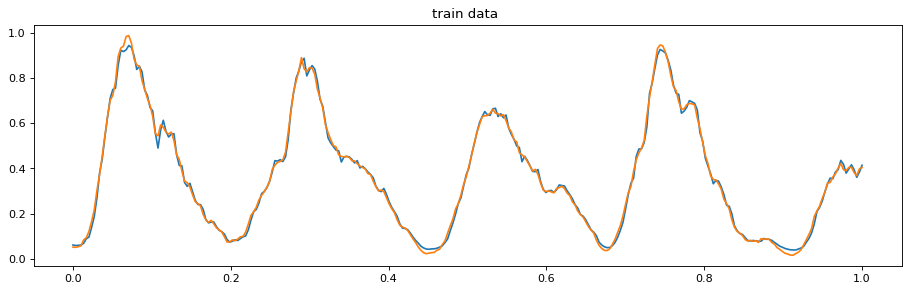

<Figure size 432x288 with 0 Axes>

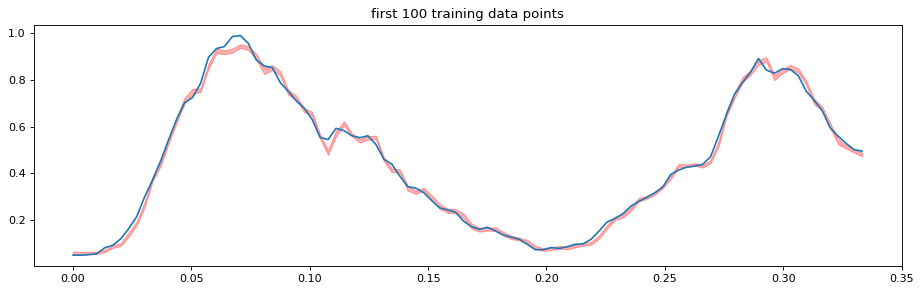

<Figure size 432x288 with 0 Axes>

In [38]:
# figure(figsize=(14, 4), dpi=80)
# for i in range(fx_train.shape[1]):
#     plt.plot(range(int(burnin)) , fx_train[int(burnin):, i])
# plt.show()
# plt.clf()


figure(figsize=(14, 4), dpi=80)
plt.title("train data ")
plt.plot(x_train , fx_train[int(burnin):,].mean(axis=0))
plt.plot(x_train , ytraindata)
plt.show()
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.title("first 100 training data points")
plt.plot(x_train[:100] , ytraindata[:100])
# plt.plot(range(100) , fx_mu_tr[:100])
# plt.plot(range(100) , fx_high_tr[:100])
# plt.plot(range(100) , fx_low_tr[:100])
plt.fill_between(x_train[:100], np.maximum.reduce(fx_train[int(burnin):,])[:100], np.minimum.reduce(fx_train[int(burnin):,])[:100], alpha=0.3, color='red')
plt.show()
plt.clf()




## Testing set

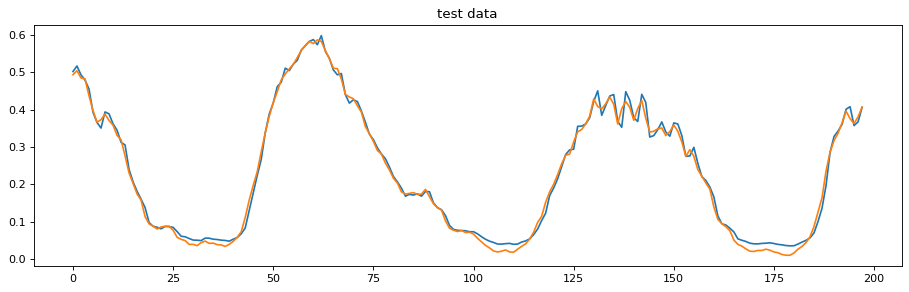

<Figure size 432x288 with 0 Axes>

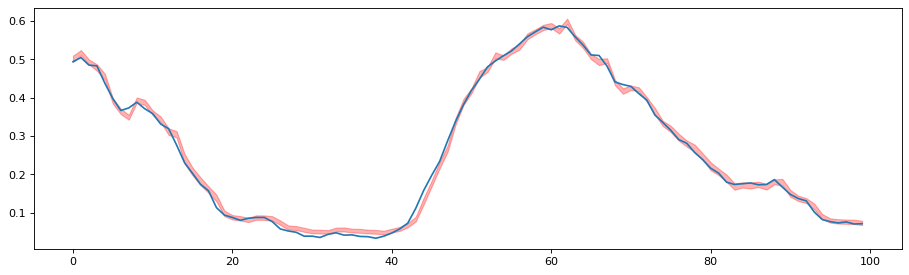

<Figure size 432x288 with 0 Axes>

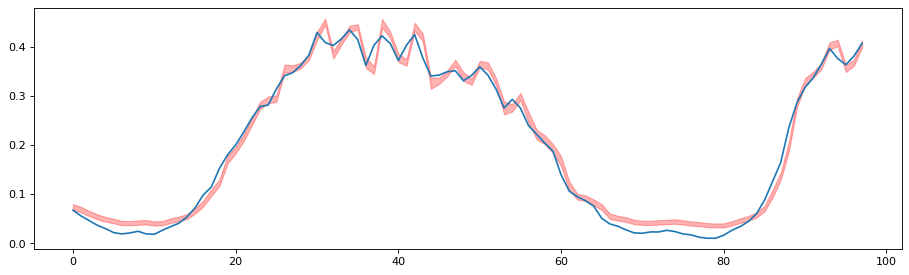

<Figure size 432x288 with 0 Axes>

In [44]:
figure(figsize=(14, 4), dpi=80)
plt.title("test data")
plt.plot(range(fx_test.shape[1]) , fx_test[int(burnin):,].mean(axis=0))
plt.plot(range(fx_test.shape[1]) , ytestdata)
plt.show()
plt.savefig('testfig1')
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.plot(range(100) , ytestdata[:100])
plt.fill_between(range(100), np.maximum.reduce(fx_test[int(burnin):,])[:100], np.minimum.reduce(fx_test[int(burnin):,])[:100], alpha=0.3, color='red')
plt.show()
plt.savefig('testfig2')
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.plot(range(98) , ytestdata[100:])

plt.fill_between(range(98), np.maximum.reduce(fx_test[int(burnin):,])[100:], np.minimum.reduce(fx_test[int(burnin):,])[100:], alpha=0.3, color='red')
plt.show()
plt.savefig('testfig3')
plt.clf()

## Trace plots for posterior weights

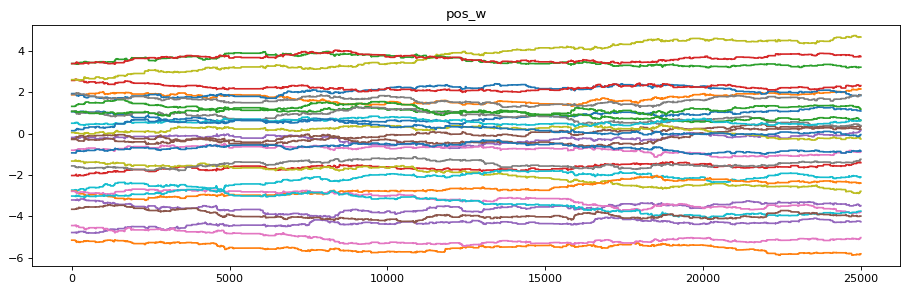

<Figure size 432x288 with 0 Axes>

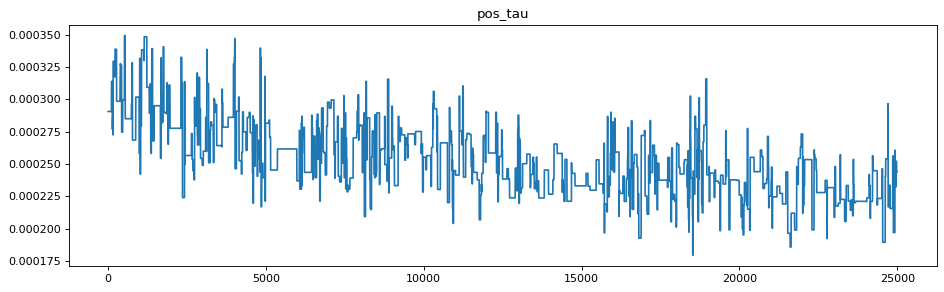

<Figure size 432x288 with 0 Axes>

In [40]:
figure(figsize=(14, 4), dpi=80)
plt.title("pos_w")
for i in range(pos_w.shape[1]):
    plt.plot(range(int(burnin)) , pos_w[:, i])
plt.show()
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.title("pos_tau")
plt.plot(range(int(burnin)), pos_tau[:, 0])
plt.show()
plt.clf()


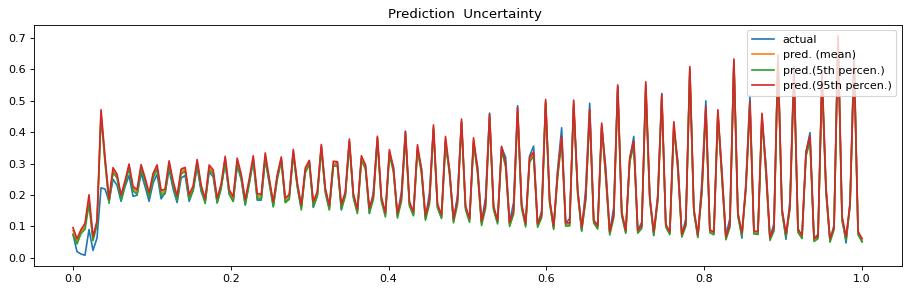

<Figure size 432x288 with 0 Axes>

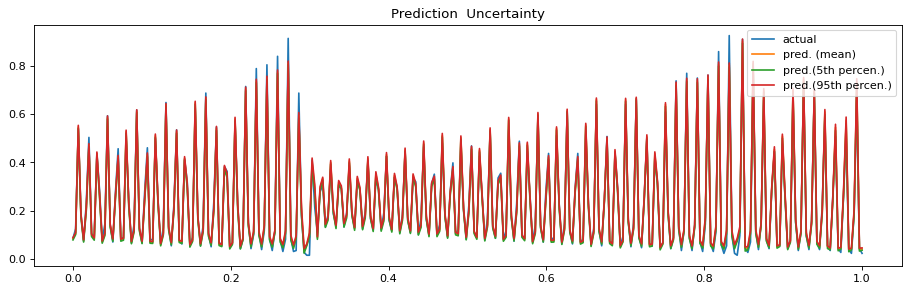

<Figure size 432x288 with 0 Axes>

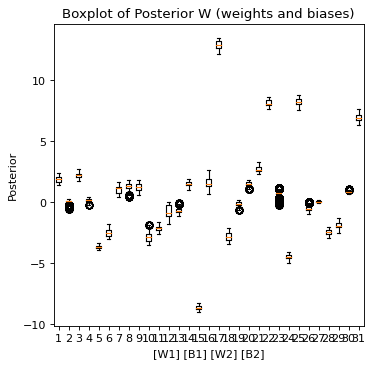

<Figure size 432x288 with 0 Axes>

In [30]:
if prob_type == 'regression':
    
    figure(figsize=(14, 4), dpi=80)
    
    plt.plot(x_test, ytestdata, label='actual')
    plt.plot(x_test, fx_mu, label='pred. (mean)')    
    
    plt.plot(x_test, fx_low, label='pred.(5th percen.)')
    plt.plot(x_test, fx_high, label='pred.(95th percen.)')
    plt.fill_between(x_test, fx_low, fx_high, facecolor='g', alpha=0.4)
    plt.legend(loc='upper right')

    plt.title("Prediction  Uncertainty ")
    plt.show()
#         plt.savefig('mcmcrestest.png') 
    plt.clf()
    
    # -----------------------------------------
    figure(figsize=(14, 4), dpi=80)
    plt.plot(x_train, ytraindata, label='actual')
    plt.plot(x_train, fx_mu_tr, label='pred. (mean)')
    plt.plot(x_train, fx_low_tr, label='pred.(5th percen.)')
    plt.plot(x_train, fx_high_tr, label='pred.(95th percen.)')
    plt.fill_between(x_train, fx_low_tr, fx_high_tr, facecolor='g', alpha=0.4)
    plt.legend(loc='upper right')

    plt.title("Prediction  Uncertainty")
    plt.show()
#         plt.savefig('mcmcrestrain.png') 
    plt.clf()

    mpl_fig = plt.figure(figsize=(5,5), dpi=80)
    ax = mpl_fig.add_subplot(111)

    ax.boxplot(pos_w)
    ax.set_xlabel('[W1] [B1] [W2] [B2]')
    ax.set_ylabel('Posterior')
#         plt.legend(loc='upper right')
    plt.title("Boxplot of Posterior W (weights and biases)")
    plt.show()
#         plt.savefig('w_pos.png')

    plt.clf()